## Importing Libraries

In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import dataframe_image as dfi

%matplotlib inline


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

### Importing the Data

In [2]:
df_listings = pd.read_csv('../data/raw/listings.csv', dtype={'price': 'object',
                                                      'weekly_price': 'object',
                                                      'monthly_price': 'object',
                                                      'security_deposit': 'object',
                                                      'cleaning_fee': 'object',
                                                      'extra_people': 'object',
                                                      'license': 'object', 
                                                      'jurisdiction_names': 'object',})

## Data Preparation

In [3]:
# Applying a new format to the numerical columns so that they can be explored
class format_data:
    
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def data_float(self):
        self = self.str.replace('$', '', regex=True).replace(',', '', regex=True).astype(float)
        
        return self
    
    def data_percentage(self):
        self = (self.str.replace('%', '', regex=True).astype('float')) / 100
        
        return self
    
    def text_to_int(self):
        self = self.str.split(' ').str[0].replace('Half-bath', '0.5', regex=True).replace('Shared', '0.5', regex=True) \
                                         .replace('Private', '1', regex=True).astype('float')
              
        return self

In [4]:
# Applying format to the price column
float_list = ['price']
for x in float_list:
    df_listings[x] = format_data.data_float(df_listings[x])

In [5]:
# Applying format to the host_response_rate and host_acceptance_rate column
percentage_list = ['host_response_rate','host_acceptance_rate']
for x in percentage_list:
    df_listings[x] = format_data.data_percentage(df_listings[x])

In [6]:
# Applying format to the bathrooms_text column
text_list = ['bathrooms_text']
for x in text_list:
    df_listings[x] = format_data.text_to_int(df_listings[x])

### Removing Price Outliers

In [7]:
def find_outliers(df_listings):
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(df_listings["price"], 25)
    
    #Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(df_listings["price"],75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
    # Display the outliers
    #print("Data points considered outliers for the feature '{}':".format("price"))
    filtered_data = df_listings[~((df_listings["price"] >= Q1 - step) & 
                                  (df_listings["price"] <= Q3 + step))].sort_values(by=["price"])
                                  
    #filtered_data["price"].hist()
    #outliers = filtered_data[filtered_data["price"] >= 1000.00]
    
    return filtered_data
                                  
                                  
outliers = find_outliers(df_listings).index
                                  
df_listings = df_listings.drop(df_listings.index[outliers]).reset_index(drop = True)

## Data Modeling

### What features assist in the pricing of a listing? 
- Could the price be predicted?
- importance of the features, rank features

### Preparing data

#### Removing rows with no target value

In [8]:
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20201216161425,2021-01-04,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039,https://www.airbnb.com/users/show/43039,...,10.0,9.0,9.0,NaN,t,2,2,0,0,1.46
1,13913,https://www.airbnb.com/rooms/13913,20201216161425,2020-12-18,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,...,10.0,9.0,9.0,NaN,f,2,1,1,0,0.17
2,15400,https://www.airbnb.com/rooms/15400,20201216161425,2020-12-28,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,...,10.0,10.0,9.0,NaN,t,1,1,0,0,0.66
3,17506,https://www.airbnb.com/rooms/17506,20201216161425,2020-12-18,Boutique Chelsea/Fulham Double bed 5-star ensuite,Enjoy a chic stay in this elegant but fully mo...,Fulham is 'villagey' and residential – a real ...,https://a0.muscache.com/pictures/11901327/e63d...,67915,https://www.airbnb.com/users/show/67915,...,NaN,NaN,NaN,NaN,f,2,0,2,0,NaN
4,25123,https://www.airbnb.com/rooms/25123,20201216161425,2021-01-03,Clean big Room in London (Room 1),Big room with double bed/ clean sheets/ clean ...,Barnet is one of the largest boroughs in Londo...,https://a0.muscache.com/pictures/456905/a004b9...,103583,https://www.airbnb.com/users/show/103583,...,10.0,9.0,10.0,NaN,t,3,0,3,0,0.99


In [9]:
# Removing rows that do not have a price
# df = df_listings.dropna(subset=["price"])
df = df_listings[df_listings['price'] != 0]

In [10]:
df = df[df['bathrooms_text'].notna()]

In [11]:
# Renaming property types to other where their total count is less than 30
counts = df['property_type'].value_counts()

df['property_type'] = np.where(df['property_type'].isin(counts.index[counts >= 30]), df['property_type'], 'Other')

#### Creating new features

In [12]:
# Creating the 'amenities - count' column
df.loc[:,"amenities_count"] = [len(i) for i in df["amenities"]]

#### Removing Features

In [13]:
def drop_columns(df):
    
    # Dropping Columns that aren't needed
    regex_list = ['url','scraped','first_review','last_review','cancellation_policy', 'maximum', 
                  'minimum', 'host','requires']
    for i in regex_list:
        df = df[df.columns.drop(list(df.filter(regex=i)))]
        
    df = df.drop(columns=['name','id','description','neighborhood_overview','latitude',
                          'longitude','neighbourhood','amenities','calendar_updated'])
    
    # remove columns with 70% or high with missing data
    col_nulls = set(df.columns[df.isnull().mean()>0.70])
    df = df.drop(list(col_nulls), axis=1)
    
    return df

df = drop_columns(df)

<AxesSubplot:>

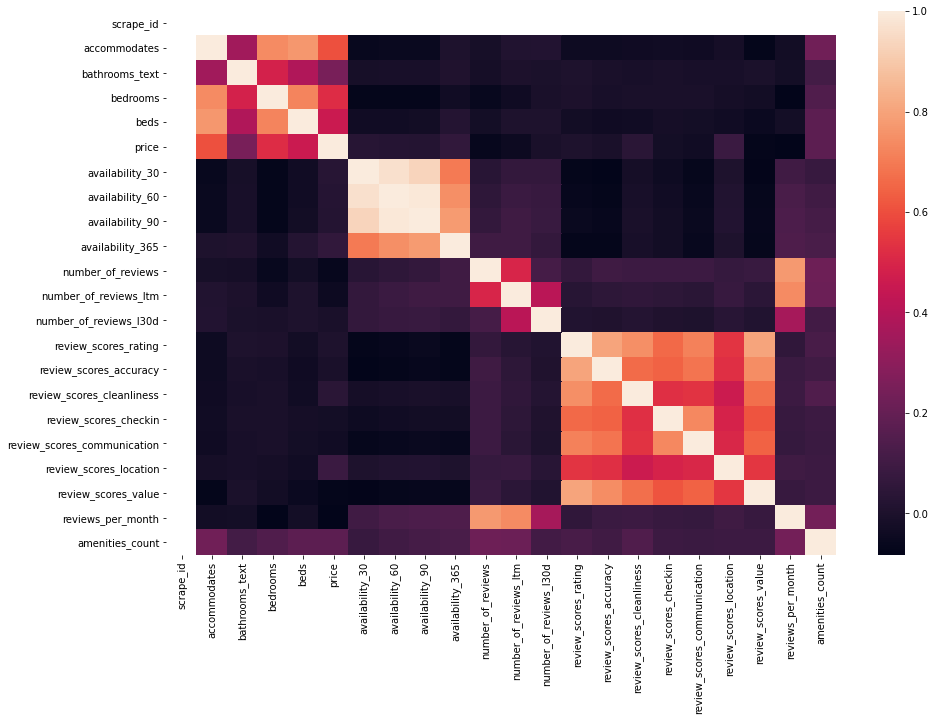

In [14]:
# calculate the correlation matrix
corr = df.corr()

plt.figure(figsize = (15,10))

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [15]:
df_object = df.select_dtypes(include=['object'])

In [16]:
df_object.columns

Index(['neighbourhood_cleansed', 'property_type', 'room_type',
       'has_availability', 'instant_bookable'],
      dtype='object')

In [17]:
new_df = df[['neighbourhood_cleansed','property_type', 'room_type', 'bathrooms_text', 
             'has_availability','instant_bookable', 'amenities_count', 'accommodates', 'bedrooms', 
             'beds', 'price']]

#### Train / Test split

In [18]:
# Extract features and labels
X = new_df.drop("price", axis=1) # drop labels for training set
y = new_df["price"].copy()

# List of features for later use
X_columns = list(X.columns)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(50152, 10)
(21495, 10)
(50152,)
(21495,)


In [21]:
X_train_num = X_train.select_dtypes(include=['float', 'int'])
X_train_cat = X_train.select_dtypes(include=['object'])

#### Data selector 

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    def get_feature_names(self):
        return X[self.attribute_names]

#### Creating the Pipeline

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

num_attribs = list(X_train_num.columns)
cat_attribs = list(X_train_cat.columns)

In [24]:
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [25]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler())
    ])

In [26]:
from sklearn.pipeline import FeatureUnion

full_pipeline = Pipeline([
       ('features', FeatureUnion([
                    ("num_pipeline", num_pipeline),
                    ("cat_pipeline", cat_pipeline)
                ])
        )])

In [27]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.fit_transform(X_test)

In [28]:
print(X_train_prepared.shape)
print(X_test_prepared.shape)

(50152, 82)
(21495, 82)


In [29]:
cat_pipeline.named_steps.cat_encoder.get_feature_names().tolist()

['x0_Barking and Dagenham',
 'x0_Barnet',
 'x0_Bexley',
 'x0_Brent',
 'x0_Bromley',
 'x0_Camden',
 'x0_City of London',
 'x0_Croydon',
 'x0_Ealing',
 'x0_Enfield',
 'x0_Greenwich',
 'x0_Hackney',
 'x0_Hammersmith and Fulham',
 'x0_Haringey',
 'x0_Harrow',
 'x0_Havering',
 'x0_Hillingdon',
 'x0_Hounslow',
 'x0_Islington',
 'x0_Kensington and Chelsea',
 'x0_Kingston upon Thames',
 'x0_Lambeth',
 'x0_Lewisham',
 'x0_Merton',
 'x0_Newham',
 'x0_Redbridge',
 'x0_Richmond upon Thames',
 'x0_Southwark',
 'x0_Sutton',
 'x0_Tower Hamlets',
 'x0_Waltham Forest',
 'x0_Wandsworth',
 'x0_Westminster',
 'x1_Boat',
 'x1_Entire apartment',
 'x1_Entire bungalow',
 'x1_Entire condominium',
 'x1_Entire cottage',
 'x1_Entire guest suite',
 'x1_Entire guesthouse',
 'x1_Entire home/apt',
 'x1_Entire house',
 'x1_Entire loft',
 'x1_Entire serviced apartment',
 'x1_Entire townhouse',
 'x1_Other',
 'x1_Private room',
 'x1_Private room in apartment',
 'x1_Private room in bed and breakfast',
 'x1_Private room in

In [30]:
cat_pipeline.named_steps.selector.attribute_names

['neighbourhood_cleansed',
 'property_type',
 'room_type',
 'has_availability',
 'instant_bookable']

In [31]:
num_pipeline.named_steps.selector.attribute_names

['bathrooms_text', 'amenities_count', 'accommodates', 'bedrooms', 'beds']

In [32]:
cat_trans_cols = cat_pipeline.named_steps.cat_encoder.get_feature_names().tolist()

In [33]:
num_cols = num_pipeline.named_steps.selector.attribute_names

In [34]:
df_column_names = cat_trans_cols + num_cols

## Model Evaluation

### Base Evaluation - Fittng the training data with various models

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor

def base_models(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    
    predict_train = model.predict(X_train)
    
    mse_train = mean_squared_error(y_train, predict_train)
    
    rmse_train = np.sqrt(mse_train)
    
    print("RMSE: Train data " + str(round(rmse_train,2)))

In [36]:
# Linear Regression - Base Model
lm = LinearRegression()
base_models(lm, X_train_prepared, X_test_prepared, y_train, y_test)

RMSE: Train data 36.04


In [37]:
# Ridge Regression - Base Model
ridge = Ridge()
base_models(ridge, X_train_prepared, X_test_prepared, y_train, y_test)

RMSE: Train data 36.04


In [ ]:
# Decision Tree Regression - Base Model
tree_reg = DecisionTreeRegressor(random_state=42)
base_models(tree_reg, X_train_prepared, X_test_prepared, y_train, y_test)

In [ ]:
# Random Forest Regression - Base Model
forest_reg = RandomForestRegressor(random_state=42)
base_models(forest_reg, X_train_prepared, X_test_prepared, y_train, y_test)

In [ ]:
# Gradient Boosting Regressor - Base Model
grad_booreg = GradientBoostingRegressor()
base_models(grad_booreg, X_train_prepared, X_test_prepared, y_train, y_test)

### Fine tune the model with cross-validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

def display_scores(model, X_train, y_train):
    
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=cv)
    rmse_scores = np.sqrt(-scores)
    
    print("RMSE Scores:", rmse_scores)
    print("RMSE Mean:", rmse_scores.mean())
    print("Standard deviation of RMSE scores:", rmse_scores.std())

In [ ]:
# Ridge Regression - CV Model
display_scores(ridge, X_train_prepared, y_train)

In [ ]:
# Random Forest Regression - CV Model
display_scores(forest_reg, X_train_prepared, y_train)

In [ ]:
display_scores(grad_booreg, X_train_prepared, y_train)

### Comparing the Train and Test scores

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# Ridge Regression:
title = r"Learning Curves for Ridge Regression"
estimator = Ridge(alpha=0.1, normalize=True)
plot_learning_curve(estimator, title, X_train_prepared, y_train, cv=cv, n_jobs=4)

# Random Forest Regression:
title = r"Learning Curves for Random Forest Regression"
estimator = RandomForestRegressor()
plot_learning_curve(estimator, title, X_train_prepared, y_train,cv=cv, n_jobs=4)

# Gradient Boosting Regressor:
title = r"Learning Curves for Gradient Boosting Regressor"
estimaGradientBoostingRegressor= GradientBoostingRegressor()
plot_learning_curve(estimator, title, X_train_prepared, y_train,cv=cv, n_jobs=4)

plt.show()

### Fine tunning the model

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [500], 'max_depth': [20]}
  ]

grad_booreg2 = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(grad_booreg2, param_grid, cv=10,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           n_jobs=-1)

grid_search.fit(X_train_prepared, y_train)

In [ ]:
grid_search.best_estimator_

In [ ]:
y_pred = grid_search.predict(X_test_prepared)

In [ ]:
mse = mean_squared_error(y_test,y_pred)

In [ ]:
rmse = np.sqrt(mse)

In [ ]:
rmse